# SciPy
![SciPy](https://raw.githubusercontent.com/scipy/scipy-sphinx-theme/master/_static/scipyshiny_small.png)

- Uses numpy as its core
- Numerical methods for:
    + integration
    + solving differential equations
    + optimizing, minimizing 
    + root finding
    + fast fourier transforms
- Contains the CODATA values for many constants of nature
- Mostly build as wrappers around time-proven fortran libraries (fftpack, lapack, fitpack)

# Table of Contents

1. [Physical constants](#physical_constants)
2. [Fitting](#fitting)
    * [General least-squares fitting using `curve_fit`](#curve_fit)
        - [Providing uncertainties and initial guesses](#uncertainties_guesses)
        - [Plotting the correlation matrix](#plot_corr_matrix)
    * [Unbinned likelihood fits using `minimize`](#minimize)
        - [A more complicated example](#minimize_complex)
    * Fitting data with x and y errors using `scipy.odr`
3. [FFTs](#fft)
4. Signal filtering with `scipy.signal.medfilt`
5. Integration
    * Function integration with `quad`
    * Numerical integration with `trapz`
6. Interpolation with `scipy.interpolate.interp1d`
7. Statistics
    * Statistical Distributions
    * Statistical Functions
        - Properties of a Gaussian (Normal) distribution
        - Computing Chi^2
        - Kolmogorov-Smirnov Tests
8. [Special Functions](#special_functions)
    * [Bessel functions](#bessel)
    * [Error function and Gaussian CDF](#erf)
    * [Orthogonal Polynomials](#ortho_polys)

In [1]:
import scipy as sp
import numpy as np

# we will need to plot stuff later
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

<a id=physical_constants></a>
## Physical constants

In [2]:
import scipy.constants as const
const.epsilon_0

8.854187817620389e-12

In [3]:
# convert temperatures:
const.convert_temperature(100, old_scale='C', new_scale='K')

373.14999999999998

In [4]:
# more constants (including units and errors)!
for k, v in const.physical_constants.items():
    print(k, ':', v)

Wien displacement law constant : (0.0028977685, 'm K', 5.1e-09)
atomic unit of 1st hyperpolarizablity : (3.20636151e-53, 'C^3 m^3 J^-2', 2.8e-60)
atomic unit of 2nd hyperpolarizablity : (6.2353808e-65, 'C^4 m^4 J^-3', 1.1e-71)
atomic unit of electric dipole moment : (8.47835309e-30, 'C m', 7.3e-37)
atomic unit of electric polarizablity : (1.648777274e-41, 'C^2 m^2 J^-1', 1.6e-49)
atomic unit of electric quadrupole moment : (4.48655124e-40, 'C m^2', 3.9e-47)
atomic unit of magn. dipole moment : (1.8548019e-23, 'J T^-1', 1.6e-30)
atomic unit of magn. flux density : (235051.755, 'T', 0.0014)
deuteron magn. moment : (4.33073482e-27, 'J T^-1', 3.8e-34)
deuteron magn. moment to Bohr magneton ratio : (0.0004669754567, '', 5e-12)
deuteron magn. moment to nuclear magneton ratio : (0.8574382329, '', 9.2e-09)
deuteron-electron magn. moment ratio : (-0.0004664345548, '', 5e-12)
deuteron-proton magn. moment ratio : (0.3070122084, '', 4.5e-09)
deuteron-neutron magn. moment ratio : (-0.44820652, '', 

In [5]:
val, unit, uncertainty = const.physical_constants['muon mass energy equivalent in MeV']

val, unit, uncertainty

(105.6583745, 'MeV', 2.4e-06)

<a id=fitting></a>
# Fitting

<a id=curve_fit></a>
## General least-squares fitting using `curve_fit`

Non-linear least-squares with Levenberg-Marquardt numerical minimization

In [6]:
from scipy.optimize import curve_fit

a = -1
b = 5

x = np.linspace(0, 5, 100)
y = np.exp(a * x) + b + np.random.normal(0, 0.1, 100)


def f(x, a, b):
    return np.exp(a * x) + b


params, covariance_matrix = curve_fit(f, x, y)

uncertainties = np.sqrt(np.diag(covariance_matrix))

print('a = {:5.2f} ± {:.2f}'.format(params[0], uncertainties[0]))
print('b = {:5.2f} ± {:.2f}'.format(params[1], uncertainties[1]))

a = -0.94 ± 0.08
b =  4.99 ± 0.02


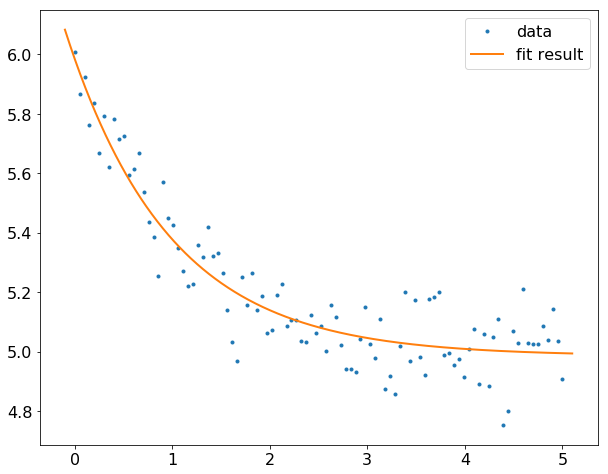

In [7]:
x_plot = np.linspace(-0.1, 5.1, 1000)

plt.plot(x, y, '.', label='data')
plt.plot(x_plot, f(x_plot, *params), label='fit result')
plt.legend()

<a id=uncertainties_guesses></a>
### Providing uncertainties and initial guesses

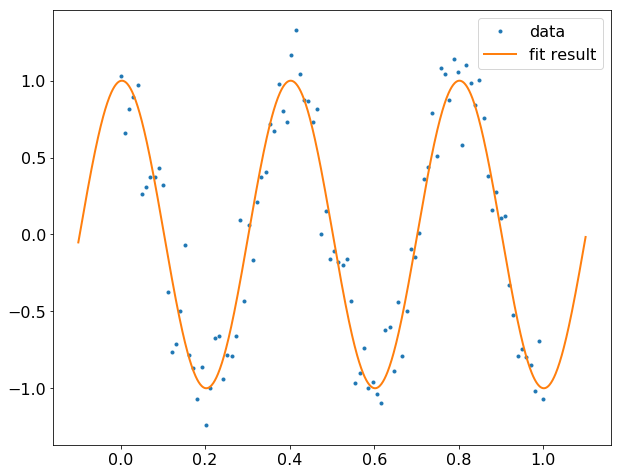

In [8]:
x = np.linspace(0, 1, 100)
y = np.sin(5 * np.pi * x + np.pi / 2) 
yerr = np.full_like(y, 0.2)

noise = np.random.normal(0, yerr, 100)

y += noise

def f(x, a, b):
    return np.sin(a * x + b)


#params, covariance_matrix = curve_fit(f, x, y)

#params, covariance_matrix = curve_fit(
#    f, x, y,
#    p0=[12, 1],
#)

params, covariance_matrix = curve_fit(
    f, x, y,
    p0=[15, 1.5],
    sigma=yerr,
    absolute_sigma=True,
)


# plot the stuff

x_plot = np.linspace(-0.1, 1.1, 1000)

plt.plot(x, y, '.', label='data')
plt.plot(x_plot, f(x_plot, *params), label='fit result')
plt.legend()

<a id=plot_corr_matrix></a>
### Plotting the correlation maxtrix

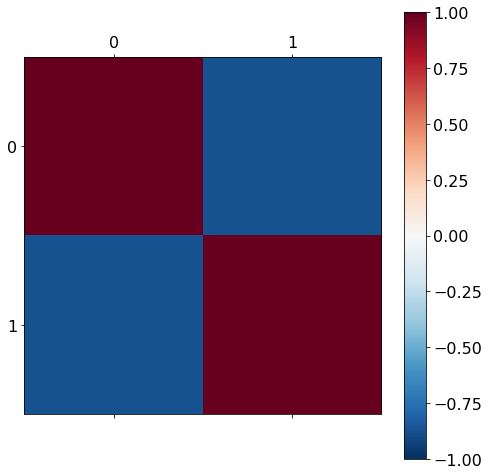

In [9]:
D = np.diag(1 / np.sqrt(np.diag(covariance_matrix)))

correlation_matrix = D @ covariance_matrix @ D


plt.matshow(correlation_matrix, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

<a id=minimize></a>
## Unbinned likelihood fits using `minimize`

Simple example: an unbinned negative log-likelihood fit for a poissonian distribution

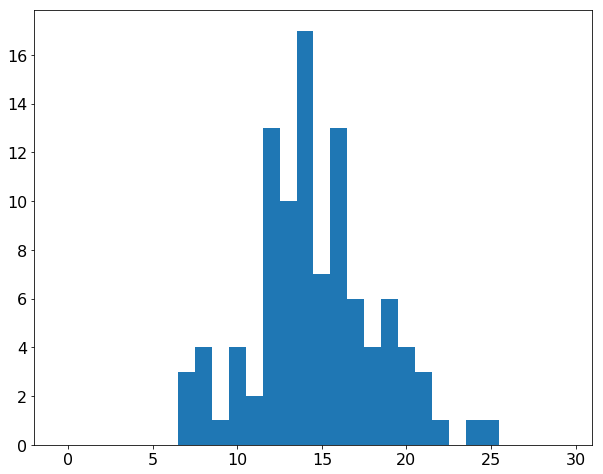

In [10]:
lambda_ = 15
k = np.random.poisson(lambda_, 100)

# make sure to use bins of integer width, centered around the integer
bin_edges = np.arange(0, 31) - 0.5

plt.hist(k, bins=bin_edges)
None

Poisson pdf:

$$ 
f(k, \lambda) = \frac{\lambda^k}{k!} \mathrm{e}^{-\lambda}
$$

So the likelihood is:

$$
\mathcal{L} = \prod_{i=0}^{N} \frac{\lambda^{k_i}}{k_i!} \mathrm{e}^{-\lambda}
$$

It's often easier to minimize $-\log(\mathcal{L})$, let's see:

$$
-\log(\mathcal{L}) = - \sum_{i=0}^{N}\bigl( k_i \log(\lambda) - \log{k_i!} - \lambda \bigr)
$$

We are interested in the minimum reletive to $\lambda$, so we dismiss constant term concerning $\lambda$ 
$$
-\log(\mathcal{L}) = \sum_{i=0}^{N}\bigl( \lambda - k_i \log(\lambda) \bigr)   
$$

This looks indeed easier to minimize than the likelihood.

In [11]:
from scipy.optimize import minimize

def negative_log_likelihood(lambda_, k):
    return np.sum(lambda_ - k * np.log(lambda_))

result = minimize(
    negative_log_likelihood,
    x0=(10, ),   # initial guess
    args=(k, ),  # additional arguments for the function to minimize
)

print(result)

      fun: -2462.337576591859
 hess_inv: array([[ 0.14466156]])
      jac: array([  3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 71
      nit: 6
     njev: 20
   status: 2
  success: False
        x: array([ 14.62999879])


* minimize has lots of options for different minimization algorithms
* Also able to respect bounds and constraints (with certain algorithms)
* It is worth to write down you problems and simplify the (log)Likelihood as much as possible

<a id=minimize_complex></a>
### A more complicated example

Fitting a gaussian with an exponential background 

Let's say we have two distributions, an exponential and a gaussian:

$$
f(x, \mu, \sigma, \tau, p) =  p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x / \tau}
$$

Likelihood:
$$
\mathcal{L} = \prod_{i = 0}^N \bigl( p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x_i / \tau} \bigr)
$$
Negative log-likelihood:

$$
-\log(\mathcal{L}) = -\sum_{i = 0}^N \log\bigl( p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x_i / \tau} \bigr)
$$

But we can make use of the built in scipy distributions:

      fun: 16589.518573758385
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0003638, -0.0003638, -0.0003638, -0.0003638])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 17
   status: 0
  success: True
        x: array([ 15.05810068,   2.50353118,   9.78011082,   0.11409398])


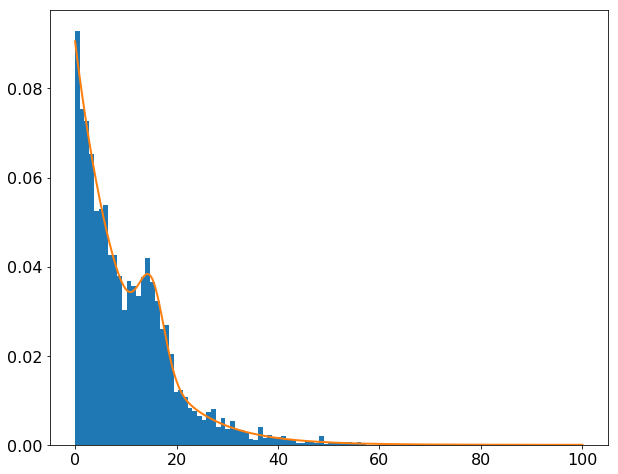

In [12]:
from scipy.stats import norm, expon

x = np.append(
    norm.rvs(loc=15, scale=2, size=500), 
    expon.rvs(scale=10, size=4500),
)

def pdf(x, mu, sigma, tau, p):
    return p * norm.pdf(x, mu, sigma) + (1 - p) * expon.pdf(x, scale=tau)


def negative_log_likelihood(params, x):
    mu, sigma, tau, p = params
    neg_l = -np.sum(np.log(pdf(x, mu, sigma, tau, p)))

    return neg_l


result = minimize(
    negative_log_likelihood,
    x0=(12, 1.5, 8, 0.2),   # initial guess
    args=(x, ),            # additional arguments for the function to minimize
    bounds=[
        (None, None),      # no bounds for mu
        (0, None),         # sigma >= 0
        (0, None),         # tau >= 0
        (0, 1),            # 0 <= p <= 1
    ],
    method='L-BFGS-B', # method that supports bounds
)

x_plot = np.linspace(0, 100, 1000)

plt.hist(x, bins=100, normed=True)
plt.plot(x_plot, pdf(x_plot, *result.x))

print(result)

In [13]:
x = expon.rvs

<a id=odr></a>
## Fitting data with x and y errors using `scipy.odr`

<Container object of 3 artists>

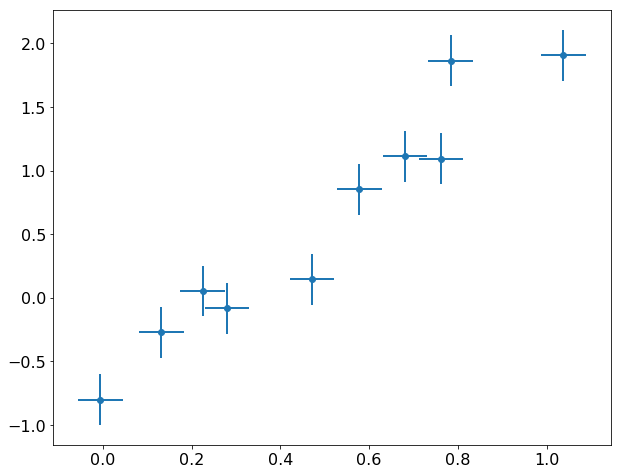

In [14]:
import numpy as np
import scipy.odr as odr

# generate some data
x = np.linspace(0, 1, 10)
y = 3*x - 1
xerr = np.full_like(x, 0.05)
yerr = np.full_like(y, 0.2)

# add noise to the data
x += np.random.normal(0, xerr, 10)
y += np.random.normal(0, yerr, 10)

# plot the data
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')

Beta: [ 2.72706393 -0.76113752]
Beta Std Error: [ 0.25799505  0.15112506]
Beta Covariance: [[ 0.05942453 -0.02938505]
 [-0.02938505  0.02038994]]
Residual Variance: 1.1201004696147643
Inverse Condition #: 0.08583523338021357
Reason(s) for Halting:
  Sum of squares convergence


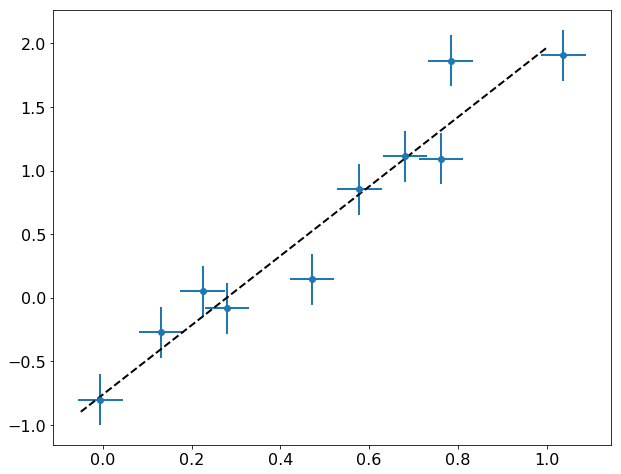

In [15]:
# function we want to fit (in this case, a line)
def f(B, x):
    return B[0]*x + B[1]

# do the fit!
guess = [4, 0]
linear = odr.Model(f)
data = odr.RealData(x, y, sx=xerr, sy=yerr)
odr_fit = odr.ODR(data, linear, beta0=guess)
output = odr_fit.run()
output.pprint()   # pprint = 'pretty print' function

# plot data and fit
z = np.linspace(-0.05, 1.0, 100)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')
plt.plot(z, f(output.beta, z), 'k--')

<a id=fft></a>
# FFTs

In [16]:
freq1 = 5
freq2 = 50

t = np.linspace(0, 1, 1024 * 10)
y = np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t)

# add some white noise
y += np.random.normal(y, 5)

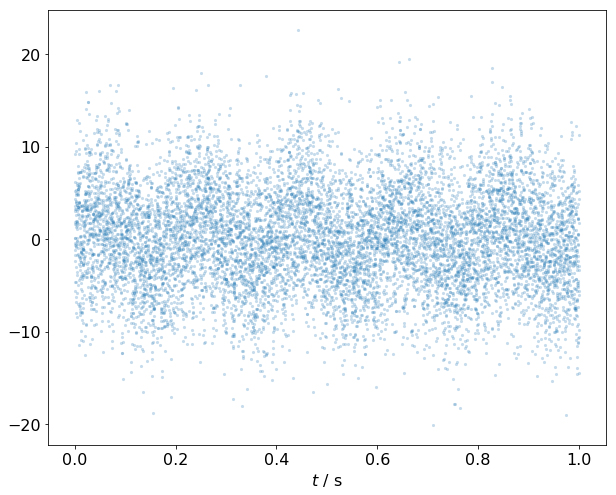

In [17]:
plt.scatter(t, y, s=10, alpha=0.25, lw=0)
plt.xlabel(r'$t \ /\ \mathrm{s}$')

In [18]:
from scipy import fftpack

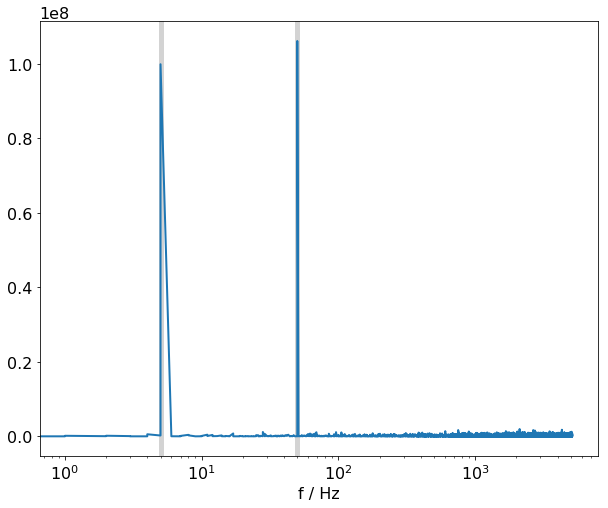

In [19]:
z = fftpack.rfft(y)
f = fftpack.rfftfreq(len(t), t[1] - t[0])

plt.axvline(freq1, color='lightgray', lw=5)
plt.axvline(freq2, color='lightgray', lw=5)

plt.plot(f, np.abs(z)**2)

plt.xlabel('f / Hz')
plt.xscale('log')
# plt.yscale('log')

<a id=special_functions></a>
# Special Functions

A complete list of scipy special functions can be found [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/special.html).

<a id=bessel></a>
## Bessel functions

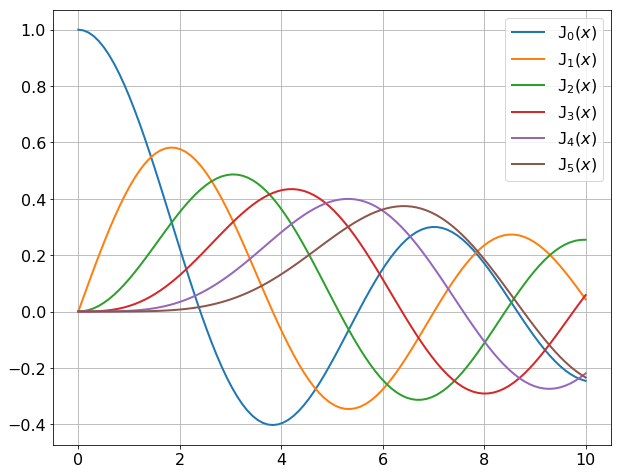

In [20]:
from scipy.special import jn


x = np.linspace(0, 10, 100)
for n in range(6):
    plt.plot(x, jn(n, x), label=r'$\mathtt{J}_{%i}(x)$' % n)
plt.grid()
plt.legend()

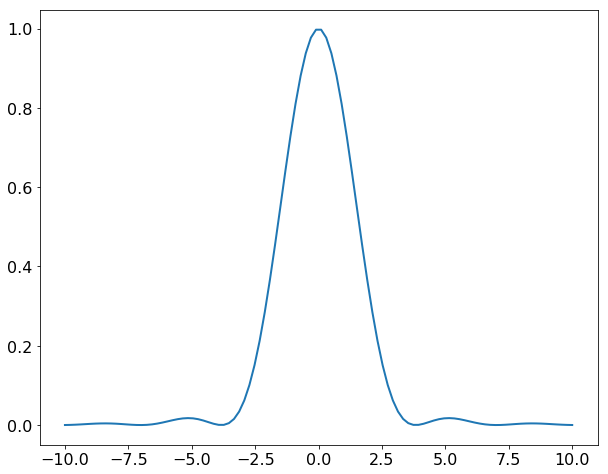

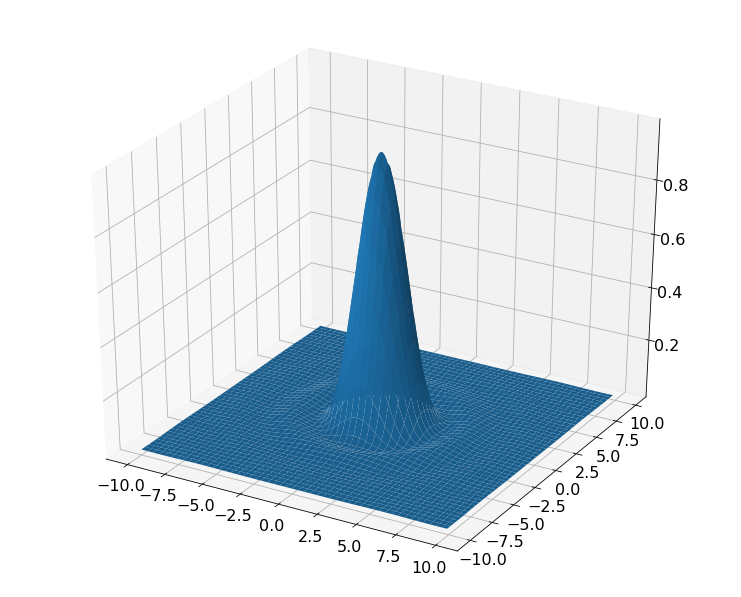

In [21]:
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

def airy_disk(x):
    return (2*jn(1, x)/x)**2

r = np.linspace(-10, 10, 100)
plt.plot(r, airy_disk(r))

x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(x, y)
Z = airy_disk(np.sqrt(X**2 + Y**2))
fig = p.figure()
ax = p3.Axes3D(fig)
ax.plot_surface(X, Y, Z)

<a id=erf></a>
## Error function and Gaussian CDF

CDF = cumulative distribution function

$$\mathrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_0^z \exp\left( -t^2 \right) dt $$
$$\mathrm{ndtr}(z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^z \exp\left( \frac{-t^2}{2} \right) dt $$

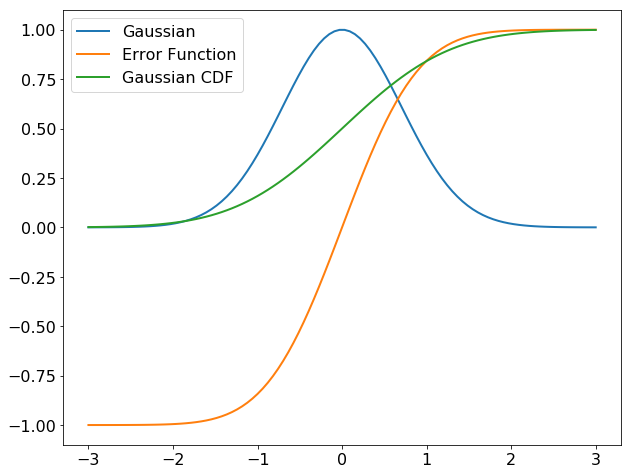

In [22]:
from scipy.special import erf, ndtr

def gaussian(z):
    return np.exp(-z**2)

x = np.linspace(-3, 3, 100)
plt.plot(x, gaussian(x), label='Gaussian')
plt.plot(x, erf(x), label='Error Function')
plt.plot(x, ndtr(x), label='Gaussian CDF')
plt.legend()

<a id=ortho_polys></a>
## Orthogonal Polynomials

In [23]:
from scipy.special import eval_legendre, eval_laguerre, eval_hermite, eval_chebyt

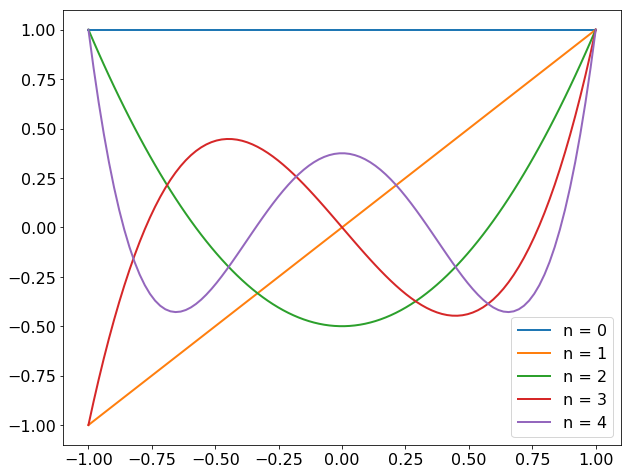

In [24]:
x = np.linspace(-1, 1, 100)
for n in range(5):
    plt.plot(x, eval_legendre(n, x), label='n = %i' % n)
#     plt.plot(x, eval_laguerre(n, x), label='n = %i' % n)
#     plt.plot(x, eval_hermite(n, x), label='n = %i' % n)
#     plt.plot(x, eval_chebyt(n, x), label='n = %i' % n)
plt.legend()